In [1]:
# Food Ingredient Prediction with GPT-4
# Zero-shot and Few-shot Learning

import os
import json
import random
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from openai import OpenAI
from dotenv import load_dotenv
from PIL import Image
from IPython.display import display
import base64

In [2]:
# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [3]:
# Load and prepare data
def load_data(file_path):
    with open(file_path, 'r') as f:
        return [json.loads(line) for line in f]

train_data = load_data('food-ingredients-101/train.jsonl')
test_data = load_data('food-ingredients-101/test.jsonl')

# Select a subset of test data for validation
VALIDATION_SIZE = 5
validation_data = random.sample(test_data, VALIDATION_SIZE)

# show 4 examples from the training set
# [{'prefix': '', 'suffix': 'pastry, butter, flour, granulated white sugar, brown sugar, baking apples, ground cinnamon, nutmeg', 'image': 'food-101/images/apple_pie/1005649.jpg'}, {'prefix': '', 'suffix': 'pastry, butter, flour, granulated white sugar, brown sugar, baking apples, ground cinnamon, nutmeg', 'image': 'food-101/images/apple_pie/1014775.jpg'}, {'prefix': '', 'suffix': 'pastry, butter, flour, granulated white sugar, brown sugar, baking apples, ground cinnamon, nutmeg', 'image': 'food-101/images/apple_pie/1026328.jpg'}, {'prefix': '', 'suffix': 'pastry, butter, flour, granulated white sugar, brown sugar, baking apples, ground cinnamon, nutmeg', 'image': 'food-101/images/apple_pie/1028787.jpg'}]
def show_examples(data):
    from IPython.display import display, HTML
    html_content = ""
    for i in range(3):
        image = Image.open(data[i]['image'])
        image = image.resize((256, 256))
        caption = data[i]['suffix']
        wrapped_caption = '<br>'.join([caption[i:i+50] for i in range(0, len(caption), 50)])
        html_content += f"<img src='{data[i]['image']}' style='width: 256px; height: 256px; margin: 10px;'><div style='display: inline-block; vertical-align: top; margin: 10px; max-width: 256px;'><p>{wrapped_caption}</p></div>"
    display(HTML(html_content))

show_examples(train_data)

In [4]:
# Helper functions for evaluation
def calculate_metrics(true_ingredients, pred_ingredients):
    true_set = set(true_ingredients.split(', '))
    pred_set = set(pred_ingredients.split(', '))
    
    accuracy = len(true_set.intersection(pred_set)) / len(true_set.union(pred_set))
    precision = len(true_set.intersection(pred_set)) / len(pred_set) if pred_set else 0
    recall = len(true_set.intersection(pred_set)) / len(true_set) if true_set else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1

def calculate_bleu(reference, hypothesis):
    return sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=SmoothingFunction().method1)

rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge(reference, hypothesis):
    scores = rouge_scorer_obj.score(reference, hypothesis)
    return (scores['rouge1'].fmeasure + scores['rouge2'].fmeasure + scores['rougeL'].fmeasure) / 3


In [5]:
# Zero-shot prediction
def zero_shot_predict(image_path):
    # Encode the image
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

    prompt = f"""Given an image of a food dish, list the main ingredients used to prepare it. 
    Provide the ingredients as a comma-separated list.
    Ingredients:"""
    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}}
            ]}
        ],
        max_tokens=200
    )
    return response.choices[0].message.content.strip()

# Few-shot prediction
def few_shot_predict(image_path, examples):
    prompt = "Given an image of a food dish, list the main ingredients used to prepare it. Provide the ingredients as a comma-separated list.\n\n"
    
    messages = []
    for example in examples:
        with open(example['image'], "rb") as image_file:
            encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
        messages.append({"role": "user", "content": [
            {"type": "text", "text": prompt},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}}
        ]})
        messages.append({"role": "assistant", "content": example['suffix']})
    messages.append({"role": "user", "content": prompt})

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        max_tokens=200
    )
    return response.choices[0].message.content.strip()

In [6]:
# Evaluation function
def evaluate(predictions, ground_truth):
    accuracies, precisions, recalls, f1_scores = [], [], [], []
    bleu_scores, rouge_scores = [], []
    
    for pred, true in zip(predictions, ground_truth):
        acc, prec, rec, f1 = calculate_metrics(true, pred)
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
        
        bleu_scores.append(calculate_bleu(true, pred))
        rouge_scores.append(calculate_rouge(true, pred))
    
    return {
        "accuracy": np.mean(accuracies),
        "precision": np.mean(precisions),
        "recall": np.mean(recalls),
        "f1": np.mean(f1_scores),
        "bleu": np.mean(bleu_scores),
        "rouge": np.mean(rouge_scores)
    }

In [7]:
# Run zero-shot prediction
print("Running zero-shot prediction...")
zero_shot_predictions = []
for sample in tqdm(validation_data):
    prediction = zero_shot_predict(sample['image'])
    zero_shot_predictions.append(prediction)

# Evaluate zero-shot results
zero_shot_results = evaluate(zero_shot_predictions, [sample['suffix'] for sample in validation_data])
print("Zero-shot results:")
for key, value in zero_shot_results.items():
    print(f"{key}: {value}")


Running zero-shot prediction...


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]

Zero-shot results:
accuracy: 0.06583333333333333
precision: 0.15090909090909094
recall: 0.10263157894736841
f1: 0.11519607843137254
bleu: 0.01705898990582353
rouge: 0.17695821133590459


In [8]:
# Run few-shot prediction
NUM_EXAMPLES = 3
print("\nRunning few-shot prediction...")
few_shot_predictions = []
for sample in tqdm(validation_data[:VALIDATION_SIZE]):
    examples = random.sample(train_data, NUM_EXAMPLES)
    prediction = few_shot_predict(sample['image'], examples)
    few_shot_predictions.append(prediction)

# Evaluate few-shot results
few_shot_results = evaluate(few_shot_predictions, [sample['suffix'] for sample in validation_data[:VALIDATION_SIZE]])
print("Few-shot results:")
for key, value in few_shot_results.items():
    print(f"{key}: {value}")


Running few-shot prediction...


100%|██████████| 5/5 [00:18<00:00,  3.72s/it]

Few-shot results:
accuracy: 0.039667229322401736
precision: 0.08605263157894737
recall: 0.0724310776942356
f1: 0.07395459976105137
bleu: 0.013826452954596169
rouge: 0.08777648079973661


In [9]:
# Run many-shot prediction
NUM_EXAMPLES_MANY = 10
print("\nRunning many-shot prediction...")
many_shot_predictions = []
for sample in tqdm(validation_data[:VALIDATION_SIZE]):
    examples = random.sample(train_data, NUM_EXAMPLES_MANY)
    prediction = few_shot_predict(sample['image'], examples)
    many_shot_predictions.append(prediction)

# Evaluate many-shot results
many_shot_results = evaluate(many_shot_predictions, [sample['suffix'] for sample in validation_data[:VALIDATION_SIZE]])
print("Many-shot results:")
for key, value in many_shot_results.items():
    print(f"{key}: {value}")


Running many-shot prediction...


100%|██████████| 5/5 [00:29<00:00,  5.84s/it]

Many-shot results:
accuracy: 0.016666666666666666
precision: 0.05714285714285714
recall: 0.021052631578947368
f1: 0.03076923076923077
bleu: 0.005142131528586245
rouge: 0.053489121072538656


In [10]:
# Print some example predictions
print("\nExample predictions:")
for i in range(3):
    print(f"\nImage: {validation_data[i]['image']}")
    print(f"Ground truth: {validation_data[i]['suffix']}")
    print(f"Zero-shot prediction: {zero_shot_predictions[i]}")
    print(f"Few-shot prediction: {few_shot_predictions[i]}")
    print(f"Many-shot prediction: {many_shot_predictions[i]}")


Example predictions:

Image: food-101/images/miso_soup/3645279.jpg
Ground truth: soba noodles, miso, firm tofu, watercress, green onions, cilantro, red pepper flakes, white miso, apple cider vinegar, fresh ginger, turmeric, water
Zero-shot prediction: Miso paste, tofu, seaweed (wakame), green onions, dashi (soup stock)
Few-shot prediction: chicken, yogurt, cream, butter, tomatoes, onion, garlic, ginger, green chili, garam masala, cumin, coriander, turmeric, chili powder, salt, flour, yeast, sugar, water
Many-shot prediction: croque monsieur, sliced ham, gruyère cheese, bechamel sauce, bread, fries, egg

Image: food-101/images/chicken_quesadilla/3534869.jpg
Ground truth: chicken, shredded cheddar cheese, cumin, jalapeno chilies, whole wheat tortillas, salsa
Zero-shot prediction: Tortillas, cheese, chicken, onions, tomato, onion, cilantro, lime, avocado, sour cream
Few-shot prediction: scallops, noodles, tomato broth, chives, herbs
Many-shot prediction: strawberries, sugar, angel food c

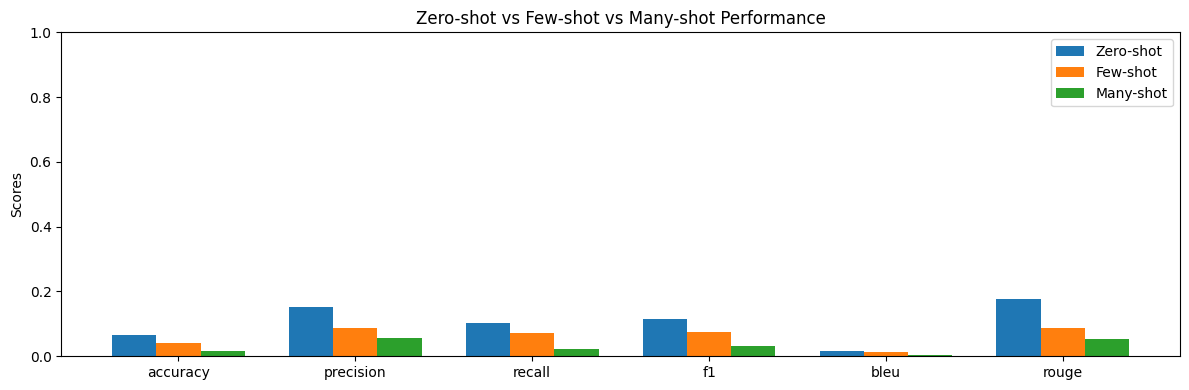

In [11]:
# Visualize results
import matplotlib.pyplot as plt

metrics = ['accuracy', 'precision', 'recall', 'f1', 'bleu', 'rouge']
zero_shot_scores = [zero_shot_results[metric] for metric in metrics]
few_shot_scores = [few_shot_results[metric] for metric in metrics]
many_shot_scores = [many_shot_results[metric] for metric in metrics]

x = range(len(metrics))
width = 0.25  # Reduced width to accommodate three bars

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar([i - width for i in x], zero_shot_scores, width, label='Zero-shot')
ax.bar([i for i in x], few_shot_scores, width, label='Few-shot')
ax.bar([i + width for i in x], many_shot_scores, width, label='Many-shot')

ax.set_ylabel('Scores')
ax.set_title('Zero-shot vs Few-shot vs Many-shot Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

ax.set_ylim(0.0, 1.0)  # Ensure y axis goes from 0.0 to 1.0
plt.tight_layout()
plt.show()